# Classification

Image classification is a super important task in computer vision where we categorize images into different groups. In this project, my goal is to figure out if species are dangerous or not by looking at their pictures. I'm going to use deep learning techniques like convolutional neural networks (CNNs) to build a really smart model. This model will learn all by itself and pick out important things from the images to make accurate predictions. Let's dive into this exciting project and use the power of deep learning to get awesome insights from images!

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

In [2]:
data = pd.read_csv('Data/preprocessed_data.csv')
data

,id,image_url,scientific_name,common_name,iconic_taxon_name,dangerous,reason
0,39,https://inaturalist-open-data.s3.amazonaws.com...,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
1,40,https://inaturalist-open-data.s3.amazonaws.com...,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
2,80,https://inaturalist-open-data.s3.amazonaws.com...,Callisaurus draconoides,Zebra-tailed Lizard,Reptilia,False,Not dangerous
3,203,http://static.inaturalist.org/photos/132/mediu...,Arctia virginalis,Ranchman's Tiger Moth,Insecta,False,Not dangerous
4,523,https://inaturalist-open-data.s3.amazonaws.com...,Malacosoma disstria,Forest Tent Caterpillar Moth,Insecta,False,Not dangerous
...,...,...,...,...,...,...,...
303661,156384671,https://static.inaturalist.org/photos/27041880...,Duttaphrynus melanostictus,Asian Common Toad,Amphibia,True,May secrete a toxic skin secretion if threaten...
303662,156387550,https://inaturalist-open-data.s3.amazonaws.com...,Bufo bufo,Common Toad,Amphibia,True,"Secretes toxic skin secretions if threatened, ..."
303663,156391245,https://static.inaturalist.org/photos/27043003...,Crotalus adamanteus,Eastern Diamondback Rattlesnake,Reptilia,True,"Highly venomous rattlesnake, can cause severe ..."
303664,156392005,https://inaturalist-open-data.s3.amazonaws.com...,Hyla arborea,European Tree Frog,Amphibia,undefined,undefined


Since I have already downloaded all the images, the image_url column can go.

In [3]:
# Remove the "image_url" column
data = data.drop('image_url', axis=1)
data = data.drop('id', axis=1)
data

,scientific_name,common_name,iconic_taxon_name,dangerous,reason
0,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
1,Taricha torosa,California Newt,Amphibia,True,"Contains tetrodotoxin (TTX), a potent neurotox..."
2,Callisaurus draconoides,Zebra-tailed Lizard,Reptilia,False,Not dangerous
3,Arctia virginalis,Ranchman's Tiger Moth,Insecta,False,Not dangerous
4,Malacosoma disstria,Forest Tent Caterpillar Moth,Insecta,False,Not dangerous
...,...,...,...,...,...
303661,Duttaphrynus melanostictus,Asian Common Toad,Amphibia,True,May secrete a toxic skin secretion if threaten...
303662,Bufo bufo,Common Toad,Amphibia,True,"Secretes toxic skin secretions if threatened, ..."
303663,Crotalus adamanteus,Eastern Diamondback Rattlesnake,Reptilia,True,"Highly venomous rattlesnake, can cause severe ..."
303664,Hyla arborea,European Tree Frog,Amphibia,undefined,undefined


## Load and transform the dataset

In [4]:
image_dir = Path('images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = [os.path.splitext(os.path.split(filepath)[1])[0] for filepath in filepaths]

# Extract the scientific name from the labels
labels = [label.split('_')[1] for label in labels]

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]



In [5]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,images\106703550_Brachycephalus_ephippium.jpg,Brachycephalus
1,images\46336816_Leptodactylus_pentadactylus.jpg,Leptodactylus
2,images\27080259_Monema_rubriceps.jpg,Monema


## Display 15 pictures of the dataset

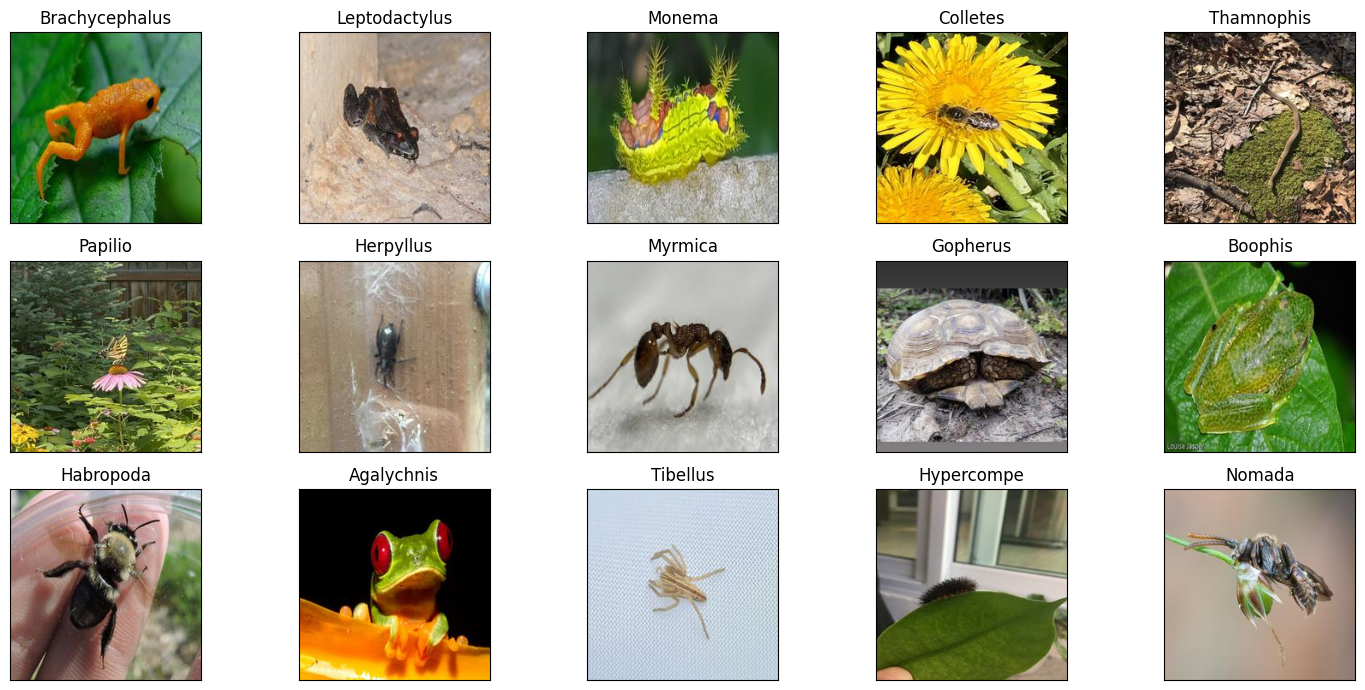

In [6]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

## Load the images with a generator

In [7]:
# Count the number of samples in each class
class_counts = image_df['Label'].value_counts()

# Filter out classes with less than 50 instances in the entire dataframe
valid_classes = class_counts[class_counts > 50].index
filtered_df = image_df[image_df['Label'].isin(valid_classes)]

# Now, split the data into train, valid, and test dataframes
train_df, temp_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['Label'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'])


In this code, we use `ImageDataGenerator` from TensorFlow's Keras API to create data generators for training and testing sets. These generators preprocess the image data using the MobileNetV2 model's `preprocess_input` function. The `validation_split` parameter reserves 20% of the training data for validation. By employing these generators, we enhance the model's performance in the image classification task.

Because the model is overfitting, I'm adding Data Augmentation.

I augment the data by applying random transformations, such as rotation, zooming, flipping, etc. This can make the model more robust and help prevent overfitting.

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In this code, we use the `flow_from_dataframe` function from TensorFlow's Keras API to create data generators for training, validation, and testing sets. These generators efficiently load and preprocess image data and corresponding labels from a dataframe. By utilizing data generators, we simplify the handling of large image datasets, enable real-time data augmentation, and streamline the training and evaluation processes for our image classification task.

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 153853 validated image filenames belonging to 990 classes.
Found 38463 validated image filenames belonging to 990 classes.
Found 24040 validated image filenames belonging to 990 classes.


## Load the pre-trained model

Now I'm loading the pretrained MobileNetV2 model. This model has already been trained on the ImageNet dataset, which contains millions of images from thousands of classes. I leave out the top layer by setting (include_top) to false. I do this so that I can add my own classification layer specific to my task.

In [10]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

## Add Custom Layer

Now I'll add a custom dense layer to the pretrained model. The Dense layer has the number of neurons equil to the number of unique labels in my dataset, and uses the softmax activation function for multi-class classification.

In [11]:
num_classes = train_df['Label'].nunique()
print("Number of classes:", num_classes)

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

Number of classes: 990


## Compile and Train the model

I now compile the model with the Adam optimizer and the categorical cross-entropy loss function, which is suitable for multi-class classification. Then I train the model using the 'fit' function on my training data and validate it on my validation data.

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[reduce_lr]
)


Epoch 1/5
4808/4808 [==============================] - 1983s 412ms/step - loss: 5.0334 - accuracy: 0.1963 - val_loss: 3.8996 - val_accuracy: 0.2892 - lr: 0.0010
Epoch 2/5
4808/4808 [==============================] - 1979s 412ms/step - loss: 4.4935 - accuracy: 0.2428 - val_loss: 3.8985 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 3/5
4808/4808 [==============================] - 2049s 426ms/step - loss: 4.4314 - accuracy: 0.2553 - val_loss: 3.9048 - val_accuracy: 0.3092 - lr: 0.0010
Epoch 4/5
4808/4808 [==============================] - 1982s 412ms/step - loss: 4.4090 - accuracy: 0.2610 - val_loss: 3.9909 - val_accuracy: 0.3089 - lr: 0.0010
Epoch 5/5
4808/4808 [==============================] - 1984s 413ms/step - loss: 4.4060 - accuracy: 0.2649 - val_loss: 4.0035 - val_accuracy: 0.3137 - lr: 0.0010


## Evaluate the model

In [13]:
loss, accuracy = model.evaluate(test_images)
print(f"Test accuracy: {accuracy}")

752/752 [==============================] - 181s 241ms/step - loss: 3.6498 - accuracy: 0.3416
Test accuracy: 0.34155574440956116


# Conclusion

At first, the model was overfitting. The model accuracy on the training data was increasing with each epoch, but the validation accuracy was not improving significantly and the validation loss was increasing. 

for this, I tried to implement the following things: 

1. Data Augmentation: Augment your data by applying random transformations, such as rotation, zooming, flipping, etc. This can make your model more robust and help prevent overfitting.
2. Regularization: Add regularization methods like Dropout or L1/L2 regularization. This can help to prevent overfitting by adding a penalty to the loss function based on the complexity of the model.
3. Use a learning rate schedule: It's often beneficial to reduce the learning rate as training progresses. This can be done using callbacks in Keras. For instance, ReduceLROnPlateau callback function reduces the learning rate when a metric has stopped improving.
4. Fine-tuning: Once your new layers have been trained, you can try to unfreeze the last few layers of the pre-trained base and continue training. Since the base model was pre-trained on ImageNet, its layers already encode a lot of useful features. By fine-tuning some of these layers, they can be adjusted to better suit the specific task.

In the next code snippet, I'm fine-tuning this model to see if this will improve the accuracy since it is now 34% accurate.

## Fine-tune the model

In [14]:
# Load the pre-trained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the pre-trained model
pretrained_model.trainable = False

# Add custom dense layer(s)
num_classes = train_df['Label'].nunique()
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile and train the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5
)

# Unfreeze the entire pre-trained model or some specific layers
pretrained_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model again (this time fine-tuning the top layers of the pre-trained model)
history_fine = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5
)


Epoch 1/5
4808/4808 [==============================] - 1984s 412ms/step - loss: 4.0354 - accuracy: 0.2618 - val_loss: 3.7197 - val_accuracy: 0.2968
Epoch 2/5
4808/4808 [==============================] - 1982s 412ms/step - loss: 3.2979 - accuracy: 0.3406 - val_loss: 3.7202 - val_accuracy: 0.3148
Epoch 3/5
4808/4808 [==============================] - 1973s 410ms/step - loss: 3.0759 - accuracy: 0.3696 - val_loss: 3.8275 - val_accuracy: 0.3126
Epoch 4/5
4808/4808 [==============================] - 1986s 413ms/step - loss: 2.9349 - accuracy: 0.3886 - val_loss: 3.8692 - val_accuracy: 0.3151
Epoch 5/5
4808/4808 [==============================] - 1984s 413ms/step - loss: 2.8289 - accuracy: 0.4027 - val_loss: 3.9878 - val_accuracy: 0.3149
Epoch 1/5
4808/4808 [==============================] - 5948s 1s/step - loss: 2.4736 - accuracy: 0.4368 - val_loss: 2.9327 - val_accuracy: 0.4004
Epoch 2/5
4808/4808 [==============================] - 5951s 1s/step - loss: 2.0651 - accuracy: 0.5046 - val_loss: 

## Evaluate the fine-tuned model

The accuracy is already better then before, now I'll evaluate and visualize it to have a closer look.

In [18]:
loss, accuracy = model.evaluate(test_images)
print(f"Test accuracy: {accuracy}")

752/752 [==============================] - 337s 446ms/step - loss: 2.6902 - accuracy: 0.4523
Test accuracy: 0.45232945680618286


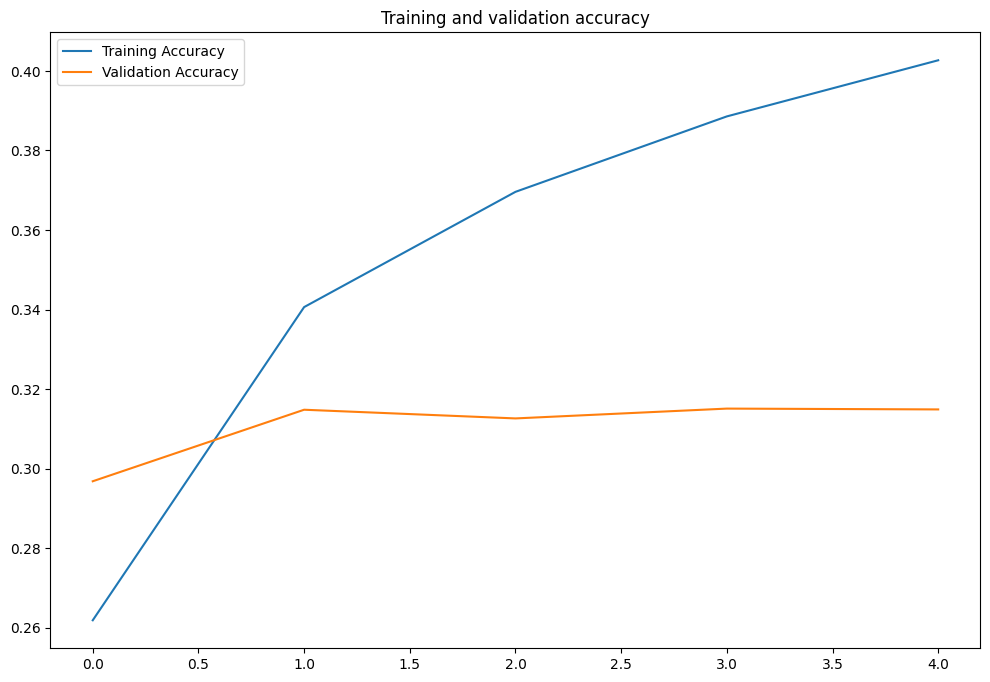

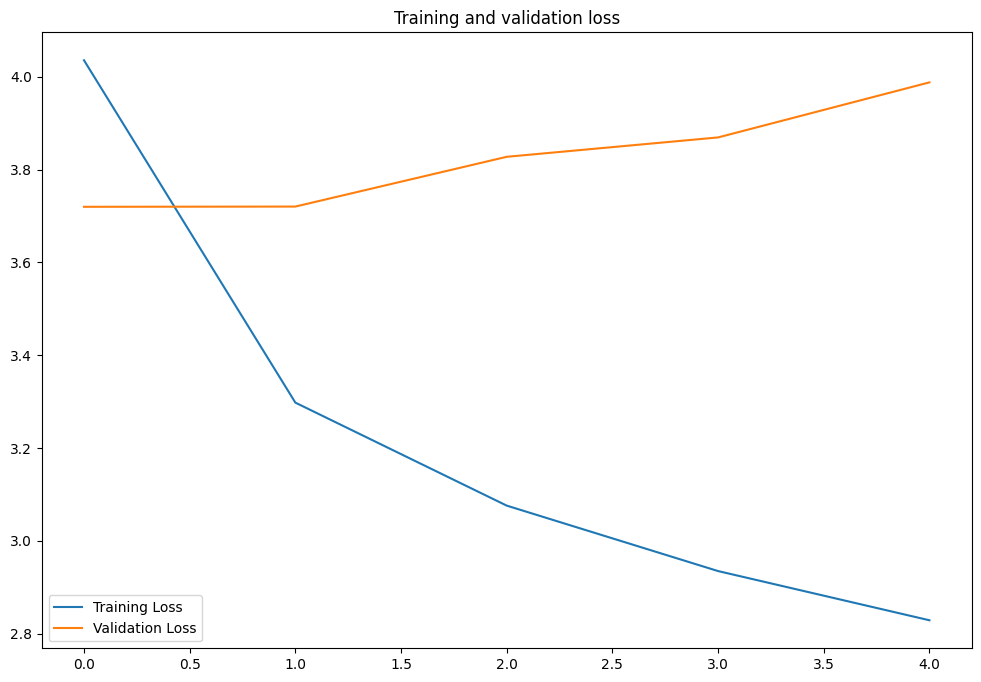

In [20]:
import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# Conclusion

The model is displaying clear signs of overfitting, evident from the considerable gap between the validation accuracy line and the training accuracy line. The model has learned the training data excessively well, capturing not just the underlying patterns but also the noise and outliers. Consequently, while it exhibits high accuracy on the training data, its ability to generalize to unseen data is compromised, resulting in lower validation accuracy.

In the second graph, a notable disparity between the validation loss and the training loss further confirms the presence of overfitting. The model's error on the validation set is significantly higher compared to the training set.

Given the extensive training time of 13.5 hours, I have decided to discontinue further improvement of this model. Although the accuracy has reached 45 percent, it could potentially be enhanced by excluding additional instances of the species from the dataset.

### Saving the model

I will now save and load this model.

In [17]:
# Save the entire model to a HDF5 file
model.save('my_model.h5')

In [16]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 990)               1268190   
                                                                 
Total params: 3,526,174
Trainable params: 3,492,062
Non-trainable params: 34,112
_________________________________________________________________


In [21]:
# test if the model is saved and loading succesfully.
test_loss, test_accuracy = new_model.evaluate(test_images)

print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

752/752 [==============================] - 360s 472ms/step - loss: 2.6902 - accuracy: 0.4523
Test loss: 2.6902003288269043, Test accuracy: 0.45232945680618286
